# Secure transmission of information using Bell states
### *Authors: Tanay Roy, Ankur Agrawal, Ziqian Li*
Here we demonstrate how to send classical information securely by using superdense coding with Bell states. In this scheme, Alice and Bob share a Bell state where Alice keeps one qubit. She performs local operations on her qubit to encode 2 bits of information and sends the qubits to Bob. Bob performs measurement in the Bell basis to extract the information deterministically. This transmission is secure since no information can be obtained by stealing the qubit to be transmitted. Apart from being secure, this method also enhances the channel capacity by a factor of 2/1=2.

We transmit two different kinds of messages - a grayscale picture and an alphanumeric text.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import pi
from random import randint
from collections import Counter
from PIL import Image as img

%matplotlib inline

from qiskit import QuantumCircuit, BasicAer, Aer, execute, IBMQ
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import partial_trace
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.tools.monitor import job_monitor

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
simulator = Aer.get_backend('qasm_simulator')
sv_simulator = BasicAer.get_backend('statevector_simulator')
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_ourense')

## Functions related to secure transmission using two Bell pairs

In [3]:
def Bell_state(qc, qubits=[0,1]):
    '''Prepares Bell state'''
    qc.h(qubits[0])
    qc.cx(qubits[0],qubits[1])

def Bell_basis_transform(qc, qubits=[0,1]):
    qc.cx(qubits[0],qubits[1])
    qc.h(qubits[0])
    
def encode_2bits_in_Bell(qc, data=0, qubits=[0,1]):
    if data == 1:
        qc.z(qubits[0])
    if data == 2:
        qc.x(qubits[0])
    if data == 3:
        qc.x(qubits[0])
        qc.z(qubits[0])
    
def encode_4bits_in_2Bell(qc, data=0, Bell1=[0,1], Bell2=[2,3]):
    left_bits = data//4
    right_bits = data%4
    
    encode_2bits_in_Bell(qc, data=right_bits, qubits=Bell1)
    encode_2bits_in_Bell(qc, data=left_bits, qubits=Bell2)
        
        
def transmit_2Bell_data_arr(data_arr=[0,1], qubits=[0,1,2,3], backend=simulator, shots=1, monitor=True):
    ''' Can transmit [0,...,15] using two Bell pairs'''
    
    circuit_list = []
    for data in data_arr:
        
        qc = QuantumCircuit(max(qubits)+1,4)
        Bell_state(qc, qubits=qubits[0:2])
        Bell_state(qc, qubits=qubits[2:4])
        
        encode_4bits_in_2Bell(qc, data=data, Bell1=qubits[0:2], Bell2=qubits[2:4])
        Bell_basis_transform(qc, qubits=qubits[0:2])
        Bell_basis_transform(qc, qubits=qubits[2:4])
        
        qc.measure(qubits, [0,1,2,3])

        circuit_list.extend([qc])
        
    # Execute on quantum hardware
    job_2Bell = execute(circuit_list, backend = backend, shots=shots)
    if monitor: job_monitor(job_2Bell)
    
    return job_2Bell.result()


def analyze_2Bell_result(results):
    # Assumes single output: shots = 1
    data_out = []
    for result in results.get_counts():
        for state,count in result.items():
            data_out.append(int(state, 2))
             
    return data_out


def transmit_2Bell_long_data(data_1d_2d, qubits=[0,1,2,3], backend=simulator, shots=1, monitor=True, max_data_per_run=75):
    
    data_1d_2d = np.array(data_1d_2d)
    is2d = False
    if len(data_1d_2d.shape) == 2:
        is2d = True
        rows, cols = data_1d_2d.shape
    data_1d_2d = data_1d_2d.flatten()
    
    data_len = len(data_1d_2d)
    runs = data_len//max_data_per_run
    remainder = data_len%max_data_per_run
    
    data_out = []
    for ii in range(runs):
        data_arr = data_1d_2d[ii*max_data_per_run:(ii+1)*max_data_per_run]
        results = transmit_2Bell_data_arr(data_arr, qubits=qubits, backend=backend, shots=shots, monitor=monitor)
        data_out.extend(analyze_2Bell_result(results))
        
    if remainder > 0:
        data_arr = data_1d_2d[-remainder:]
        results = transmit_2Bell_data_arr(data_arr, qubits=qubits, backend=backend, shots=shots, monitor=monitor)
        data_out.extend(analyze_2Bell_result(results))
        
    data_out = np.array(data_out)
    if is2d: data_out = data_out.reshape(rows,cols)
    return data_out
    

def check_final_state_vector(qc):
    state_result = execute(qc, backend=sv_simulator).result()
    return chop(state_result.get_statevector(qc))


def find_majority(votes):
    vote_count = Counter(votes)
    top_two = vote_count.most_common(2)
    if len(top_two)>1 and top_two[0][1] == top_two[1][1]:
        # It is a tie
        return -1
    return top_two[0][0]


def find_majority_arr(int_1d_arr_arr, bits=4):
    int_1d_arr_arr = np.transpose(int_1d_arr_arr)
    maj_int_1d_arr = []
    for int_1d_arr in int_1d_arr_arr:
        # First convert integer 1d array to binary 2d array and tranpose
        bin_2d_arr = np.transpose([list(format(ii,'b').zfill(bits)) for ii in int_1d_arr])
        maj_bin_arr = []
        for bin_arr in bin_2d_arr:
            maj_bin_arr.extend(find_majority(bin_arr))
            
        maj = int("".join(maj_bin_arr),2) # Binary string to integer
        maj_int_1d_arr.append(maj)        
        
    return maj_int_1d_arr


def check_success_rate(data_in, data_out):
    correct_count = np.sum(np.multiply(np.array(data_in)==np.array(data_out),1))
    print("Success = %s/%s = %s %%" %(correct_count,data_in.size,correct_count/data_in.size*100))

## Explicit quantum circuit for transmission using two Bell pairs

Output bitstring: {'1110': 1}


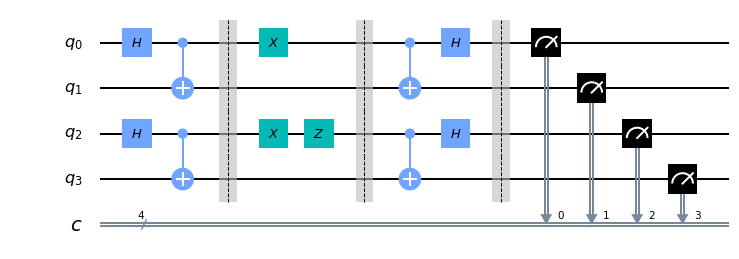

In [5]:
val = 14 # data to be transmitted. Binary(14): '1110'

qubits= [0,1,2,3]
qc = QuantumCircuit(max(qubits)+1,4)
# === Prepare two Bell pairs === #
Bell_state(qc, qubits=qubits[0:2])
Bell_state(qc, qubits=qubits[2:4])
# === Alice keeps q0,q2 and Bob keeps q1,q3 === #
qc.barrier(qubits)

# === Alice encodes information by applying local operations on q0 and q2 === #
encode_4bits_in_2Bell(qc, data=val, Bell1=qubits[0:2], Bell2=qubits[2:4])
# === Alice send q0 and q2 to Bob === #
qc.barrier(qubits)

# === Bob applies gates to perform measurement on Bell basis === #
Bell_basis_transform(qc, qubits=qubits[0:2])
Bell_basis_transform(qc, qubits=qubits[2:4])
qc.barrier(qubits)
# === Bob performs measurement to recover information (in binary) === #
qc.measure(qubits, [0,1,2,3])
job_2Bell = execute(qc, backend = simulator, shots=1)

print("Output bitstring:", job_2Bell.result().get_counts())
qc.draw('mpl') # Draw the quantum circuit

The above circuit shows that Alice can transmit 4 bits of classical information by performing local operations (X and Z gates) on her two qubits (q0 and q2) and sending those to Bob. Thus the channel capacity enhancement is 4/2 = 2. This transmission is secure since all the information is encoded in the correlation and no information can be obtained by measuring the qubits transmitted by Alice alone.

# Part 1: Image transmission

## Functions related to image processing

In [4]:
def resize_image(file_in, x_pixels=20, y_pixels=20, file_out=None):
    image = img.open(file_in)
    new_image = image.resize((x_pixels, y_pixels))
    if file_out is not None:
        new_image.save(file_out)
    print("Input size: %s, Output size: %s" %(image.size, new_image.size))

    
def convert_to_gray(file_in, file_out=None):
    
    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

    image = mpimg.imread(file_in) 
    gray = rgb2gray(image)
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=max(gray.flatten()))
    if file_out is not None: plt.savefig(file_out)
    return gray


def change_resolution_grayscale_arr(gray_arr, bit_res=4):
    # Use max and min of data to set the full scale
    gray_arr = gray_arr - min(gray_arr.flatten())
    gray_arr = gray_arr/max(gray_arr.flatten())
    res = 2**bit_res - 1
    gray_new = np.round(gray_arr * res)
    return gray_new.astype(int)


def plot_gray_2d_arr(gray_2d_arr):
    plt.imshow(gray_2d_arr, cmap=plt.get_cmap('gray'), vmin=0, vmax=max(gray_2d_arr.flatten()))


### Step 1: Choose a color image (40 X 40 pixels)

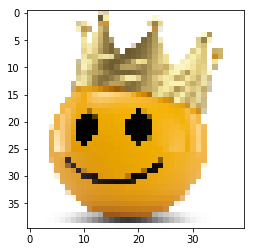

In [10]:
plt.imshow(img.open('happy_small.png'))
plt.show()

### Step 2: Convert the image into grayscale with 4 bit resolution

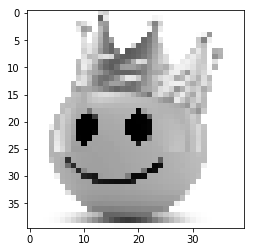

In [31]:
plot_gray_2d_arr(gray_2d_arr)

This is the image to be transmitted securely


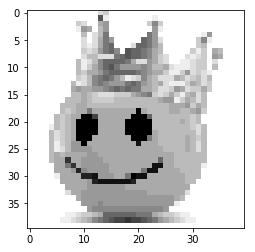

In [5]:
gray_2d_arr = convert_to_gray('happy_small.png')
pic_40_40 = change_resolution_grayscale_arr(gray_2d_arr, bit_res=4)
plot_gray_2d_arr(pic_40_40)
print("This is the image to be transmitted securely")

In [19]:
# Check that all elements are within 0--15
print("20th row:", pic_40_40[20])
print("Max=%s, min=%s" %(max(pic_40_40.flatten()), min(pic_40_40.flatten())))

20th row: [15 15 15 15 15 11 12 11 10  0  0  0  0 10 10 10 10 10  0  0  0  0  0 11
 11 11 11 11 10 11 12 11 15 15 15 15 15 15 15 15]
Max=15, min=0


Essentially, Alice is going to transmit 40\*40=1600 4-bit numbers = 6400 bits of classical informatino using 3200 qubits.

### Step 3: Check the performance using the simulator first

Success = 1600/1600 = 100.0 %


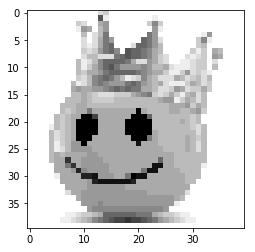

In [23]:
data_in = pic_40_40
data_out = transmit_2Bell_long_data(data_in, qubits=[0,1,2,3], backend = simulator, monitor=False)

check_success_rate(data_in, data_out)
plot_gray_2d_arr(data_out)

Of course, an ideal simulator works 100% of the times

### Step 4: Perform the experiment on a real quantum hardware
We have selected the "ibmq_ourense" processor, which seem to have the best performace. It is a 5-qubit processor as shown below. We have used qubits 1,2,3, and 4.
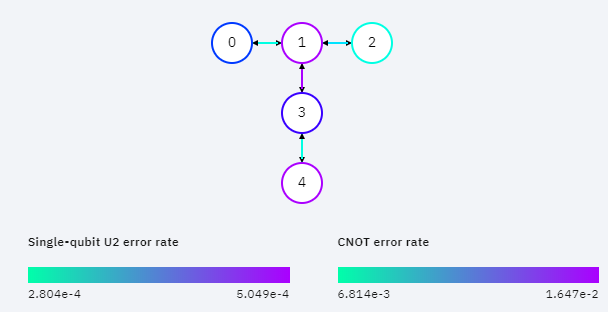

#### Run 1

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Success = 884/1600 = 55.25 %


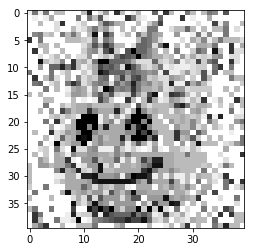

In [29]:
happy_data_out1 = transmit_2Bell_long_data(data_in, qubits=[2,1,3,4], backend = qcomp, monitor=True)

check_success_rate(pic_40_40, happy_data_out1)
plot_gray_2d_arr(happy_data_out1)

#### Run 2

Success = 854/1600 = 53.37499999999999 %


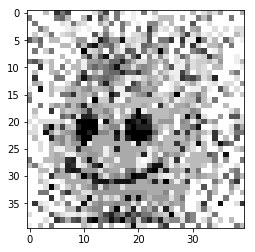

In [27]:
happy_data_out2 = transmit_2Bell_long_data(data_in, qubits=[2,1,3,4], backend = qcomp, monitor=False)

check_success_rate(pic_40_40, happy_data_out2)
plot_gray_2d_arr(happy_data_out2)

#### Run 3

Success = 930/1600 = 58.12500000000001 %


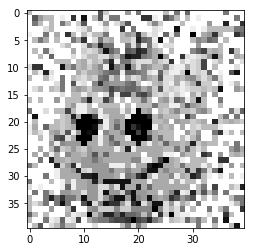

In [28]:
happy_data_out3 = transmit_2Bell_long_data(data_in, qubits=[2,1,3,4], backend = qcomp, monitor=False)

check_success_rate(pic_40_40, happy_data_out3)
plot_gray_2d_arr(happy_data_out3)

#### Run 4

Success = 860/1600 = 53.75 %


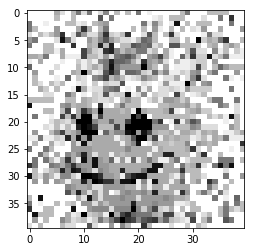

In [30]:
happy_data_out4 = transmit_2Bell_long_data(data_in, qubits=[2,1,3,4], backend = qcomp, monitor=False)

check_success_rate(pic_40_40, happy_data_out4)
plot_gray_2d_arr(happy_data_out4)

#### Run 5

Success = 832/1600 = 52.0 %


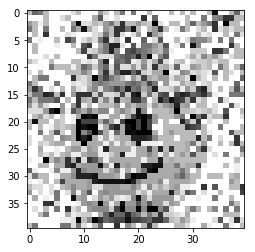

In [31]:
happy_data_out5 = transmit_2Bell_long_data(data_in, qubits=[2,1,3,4], backend = qcomp, monitor=False)

check_success_rate(pic_40_40, happy_data_out5)
plot_gray_2d_arr(happy_data_out5)

##### The average transmission success rate (after 5 runs) = 54.5%

### Step 5: Classical error-correction using majority vote

Using majority vote of 3 runs
Success = 1232/1600 = 77.0 %


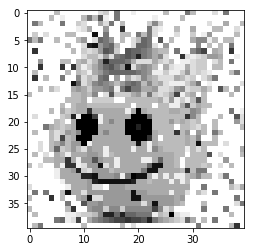

In [36]:
# Majority vote using 3 runs
data1 = happy_data_out1.flatten()
data2 = happy_data_out2.flatten()
data3 = happy_data_out3.flatten()
maj_data_out = find_majority_arr([data1,data2,data3], bits=4)

maj_data_out = np.array(maj_data_out).reshape(40,40)
print("Using majority vote of 3 runs")
check_success_rate(pic_40_40, maj_data_out)
plot_gray_2d_arr(maj_data_out)

Using majority vote of 5 runs
Success = 1380/1600 = 86.25 %


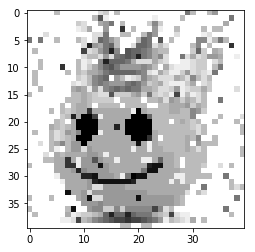

In [38]:
# Majority vote using 5 runs
data4 = happy_data_out4.flatten()
data5 = happy_data_out5.flatten()
maj_data_out = find_majority_arr([data1,data2,data3,data4,data5], bits=4)

maj_data_out = np.array(maj_data_out).reshape(40,40)
print("Using majority vote of 5 runs")
check_success_rate(pic_40_40, maj_data_out)
plot_gray_2d_arr(maj_data_out)

# Part 2: Text message transmission

In [7]:
# Import functions related to conversion of text to binary message
try:
    import RS 
except:
    !jupyter nbconvert --to python RS.ipynb
    import RS
    
def check_success_rate_string(string_in, string_out):
    print("Original message:", string_in)
    print("Received message:", string_out)
    correct_count = np.sum(np.multiply([x==y for x,y in zip(list(string_in),list(string_out))],1))
    print("Success rate = %s/%s = %s %%" %(correct_count,len(string_in),correct_count/len(string_in)*100))
    
transmission_type = 0 # 0 for Bell state, 1 for GHZ state
is_picture = 0 # 0 is no, 1 is yes

### Step 1: Convert input text message to arrays of 4 bits
*Text message*: We Love Qiskit Summer Jam 2020.

In [8]:
message = 'We Love Qiskit Summer Jam 2020.' # input message
package, parity = RS.transmitting(message, transmission_type, is_picture) # Encoding the text message into arrays of 4 bits

### Step 2: Check the performance using the simulator first

In [9]:
package_out = transmit_2Bell_long_data(package, qubits=[2,1,3,4], backend = simulator, monitor=False)

msg_received = RS.receiving(package_out, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Original message: We Love Qiskit Summer Jam 2020.
Received message: We Love Qiskit Summer Jam 2020.
Success rate = 31/31 = 100.0 %


### Step 3: Check the performance on the quantum hardware: "ibmq_ourense"

#### Run 1

In [10]:
package_out1 = transmit_2Bell_long_data(package, qubits=[0,1,3,4], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out1, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
Received message: we!Lofe 1:smIt0Sum}i6%JiI 3020.
Success rate = 16/31 = 51.61290322580645 %


#### Run 2

In [21]:
package_out2 = transmit_2Bell_long_data(package, qubits=[1,2,3,4], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out2, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
Received message: W% Lke Qhsoid w}mur B M "02 6
Success rate = 15/31 = 48.38709677419355 %


#### Run 3

In [26]:
package_out3 = transmit_2Bell_long_data(package, qubits=[1,2,3,4], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out3, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
ve`Ais+it Su}er0Zei :00.
Success rate = 15/31 = 48.38709677419355 %


#### Run 4

In [13]:
package_out4 = transmit_2Bell_long_data(package, qubits=[1,2,3,4], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out4, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
Received message: ! Hgfe QhQkiD RumE`b J`! 002 &
Success rate = 13/31 = 41.935483870967744 %


#### Run 5

In [14]:
package_out5 = transmit_2Bell_long_data(package, qubits=[1,2,3,4], backend = qcomp, monitor=True)

msg_received = RS.receiving(package_out5, transmission_type, is_picture, parity) # Decode received package
check_success_rate_string(message, msg_received)

Job Status: job has successfully run
Original message: We Love Qiskit Summer Jam 2020.
Received message: ;e Lowe0QhscId Summer0JiM00:0.
Success rate = 18/31 = 58.06451612903226 %


##### The average transmission success rate (after 5 runs) = 49.7%

### Step 5: Classical error-correction using majority vote

In [27]:
# Majority vote using 3 runs
maj_data_out = find_majority_arr([package_out1,package_out2,package_out3], bits=4)

msg_received = RS.receiving(maj_data_out, transmission_type, is_picture, parity) # Decode received package
print("Using majority vote of 3 runs")
check_success_rate_string(message, msg_received)

Using majority vote of 3 runs
Original message: We Love Qiskit Summer Jam 2020.
Received message: We Love Qhsoit Su}}er JaI 2020.
Success rate = 26/31 = 83.87096774193549 %


In [29]:
# Majority vote using 5 runs
maj_data_out = find_majority_arr([package_out1,package_out2,package_out3,package_out4,package_out5], bits=4)

msg_received = RS.receiving(maj_data_out, transmission_type, is_picture, parity) # Decode received package
print("Using majority vote of 5 runs")
check_success_rate_string(message, msg_received)

Using majority vote of 5 runs
Original message: We Love Qiskit Summer Jam 2020.
Received message: e Love Qhskid Summer JaI 2020.
Success rate = 27/31 = 87.09677419354838 %
